# リポジトリクローン

In [1]:
!git clone https://github.com/liuh127/NTIRE-2021-Dehazing-Two-branch

Cloning into 'NTIRE-2021-Dehazing-Two-branch'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 140 (delta 67), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (140/140), 23.50 MiB | 18.40 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [2]:
%cd NTIRE-2021-Dehazing-Two-branch

/content/NTIRE-2021-Dehazing-Two-branch


# 学習済みモデルダウンロード

In [3]:
!gdown https://drive.google.com/uc?id=1M2n6g7S5_sqPmTIAuI-IC30fhUmQr199
!gdown https://drive.google.com/uc?id=1aZQyF16pziCxKlo7BvHHkrMwb8-RurO_

Downloading...
From: https://drive.google.com/uc?id=1M2n6g7S5_sqPmTIAuI-IC30fhUmQr199
To: /content/NTIRE-2021-Dehazing-Two-branch/best.pkl
100% 202M/202M [00:01<00:00, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aZQyF16pziCxKlo7BvHHkrMwb8-RurO_
To: /content/NTIRE-2021-Dehazing-Two-branch/res2net101_v1b_26w_4s-0812c246.pth
100% 182M/182M [00:01<00:00, 113MB/s]


# サンプル画像読み込み

In [4]:
!pip install imread_from_url

  Created wheel for imread-from-url: filename=imread_from_url-0.1.3-py3-none-any.whl size=6644 sha256=cf24c9c8b48855c96aa7202eef7100c3f518435b2315dcff47db3a59e81633c6
  Stored in directory: /root/.cache/pip/wheels/85/f3/52/03dd8278e2b87654827dc9f1833c7c84c56d82c15ee205145e
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=1e8b6004330d8fcb746e798542dbbbf2329eb06a03cd61b8e5916590f893fc5a
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
Successfully built imread-from-url fake-useragent


In [5]:
from imread_from_url import imread_from_url

image = imread_from_url(
    'https://raw.githubusercontent.com/Kazuhito00/NTIRE-2021-Dehazing-Two-branch-Colaboratory-Sample/main/sample.jpg'
)

Error occurred during loading data. Trying to use cache server https://fake-useragent.herokuapp.com/browsers/0.1.11
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/fake_useragent/utils.py", line 154, in load
    for item in get_browsers(verify_ssl=verify_ssl):
  File "/usr/local/lib/python3.7/dist-packages/fake_useragent/utils.py", line 99, in get_browsers
    html = html.split('<table class="w3-table-all notranslate">')[1]
IndexError: list index out of range


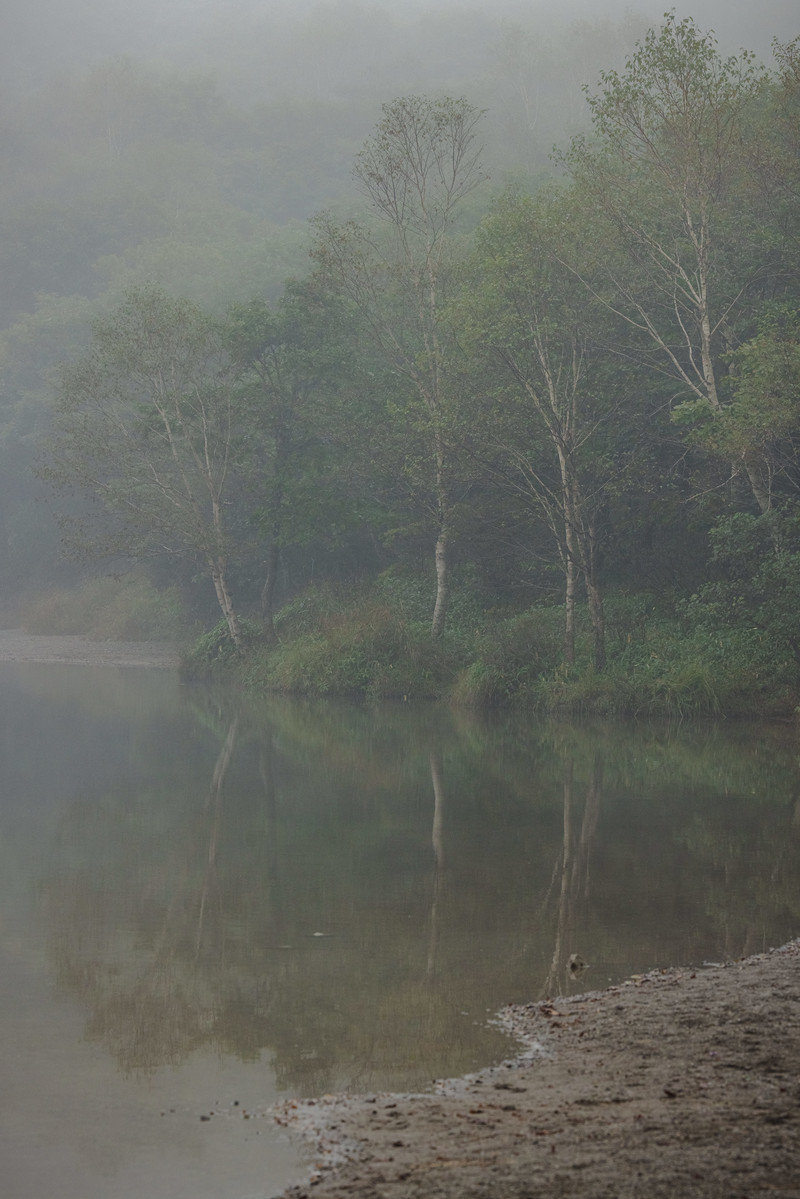

In [6]:
from google.colab.patches import cv2_imshow

cv2_imshow(image)

# 推論確認

In [7]:
import torch

# GPUデバイスID取得
device_ids = [Id for Id in range(torch.cuda.device_count())]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
from model import fusion_refine

# モデル定義
imagenet_model = ''
rcan_model = ''
dehazing_net = fusion_refine(imagenet_model, rcan_model)
print('parameters:', sum(param.numel() for param in dehazing_net.parameters()))

# マルチGPU設定
dehazing_net = dehazing_net.to(device)
dehazing_net= torch.nn.DataParallel(dehazing_net, device_ids=device_ids)

# モデル重み読み込み
dehazing_net.load_state_dict(torch.load('best.pkl'))

dehazing_net.eval()

parameters: 50353285


DataParallel(
  (module): fusion_refine(
    (feature_extract): Dehaze(
      (encoder): Res2Net(
        (conv1): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
          (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottle2neck(
            (conv1): Conv2d(64, 104, kernel_size=(1, 1), 

In [9]:
  import cv2
  import numpy as np

  # 前処理
  input_image = cv2.resize(image, dsize=(1600, 1200))
  input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
  input_image = input_image / 255.0
  input_image = input_image.transpose(2, 0, 1).astype('float32')
  input_image = np.expand_dims(input_image, axis=0)
  print(input_image.shape)

  input_tensor = torch.from_numpy(input_image).to(device)

(1, 3, 1200, 1600)


In [10]:
%%time

with torch.no_grad():
    output_tensor = dehazing_net(input_tensor)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3792: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


CPU times: user 336 ms, sys: 258 ms, total: 595 ms
Wall time: 769 ms


In [11]:
# 後処理
output_image = output_tensor.squeeze().cpu().detach().numpy()

output_image = output_image.transpose(1, 2, 0)
output_image = np.clip(output_image * 255.0, 0, 255).astype(np.uint8)
output_image = cv2.resize(output_image, dsize=(image.shape[1], image.shape[0]))
output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)

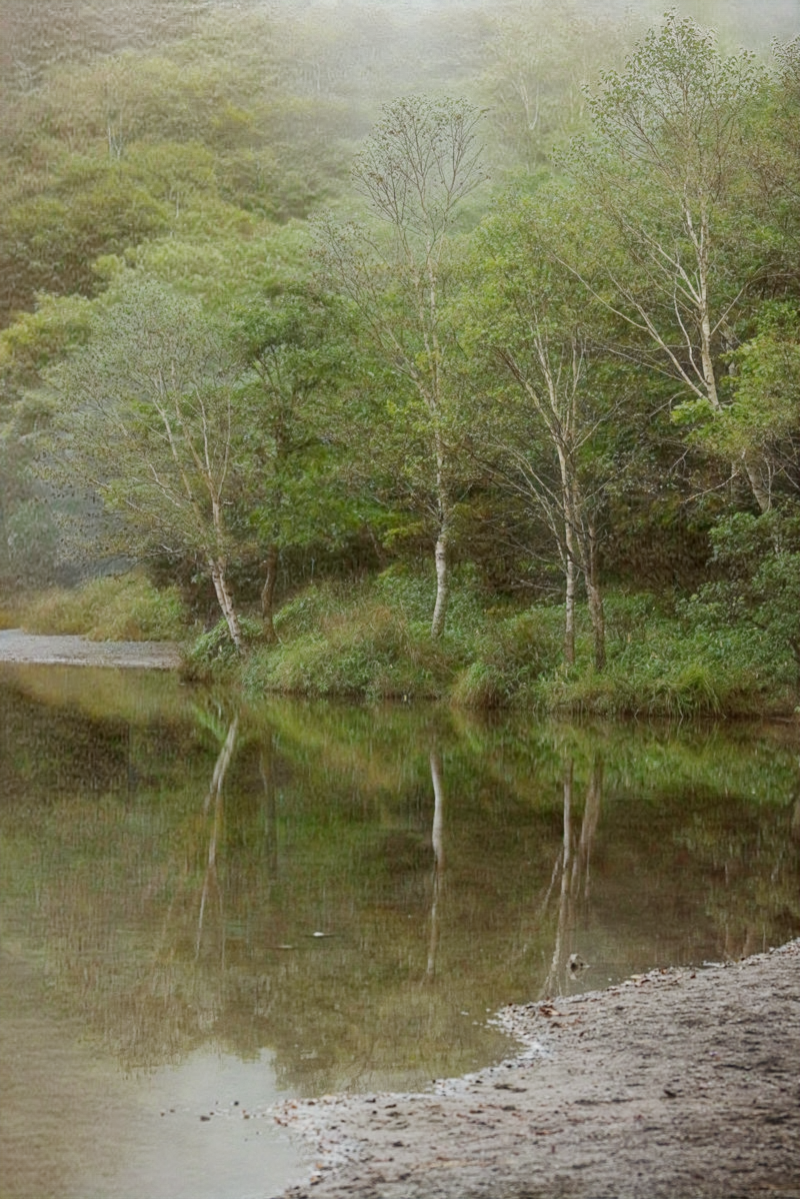

In [12]:
from google.colab.patches import cv2_imshow

cv2_imshow(output_image)